# Assignment 1


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from scipy.stats import poisson 
from scipy.integrate import odeint
import sys

register_matplotlib_converters()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 7, 'font.style': 'normal', 'font.family':'serif'})

## Exercise 1

In the first task we define SEIR model and calibrate the model on the the first
part of the data that is provided (where you have exponential growth).

In [2]:
# read data from csv file
data = pd.read_csv('data_provinces.csv').drop(columns='Unnamed: 0')

# list of provinces
provinces = data.columns.tolist() 

data.head()

,LO,PV,SO,MN,MI,CO,BS,MB,LC,CR,BG,VA
0,0,0,0,1,0,1,2,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0


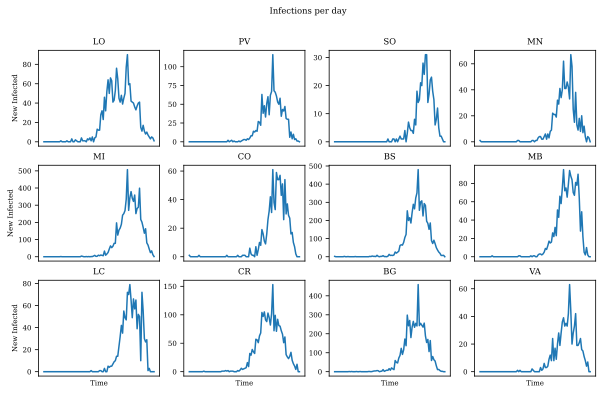

In [3]:
#Plots Infections per day
fig, axs = plt.subplots(3, 4, facecolor='w', figsize=(10,6))

fig.suptitle('Infections per day')

for r in range(3):
    for c in range(4):
        idx = (r * 4) + c # convert 2d index to 1d index
        province = provinces[idx] # current province
        axs[r, c].plot(data[province]) # plot new infections
        axs[r, c].set_title(province)
        axs[r, c].set_xticks([])
        if r == 2:
            axs[r, c].set_xlabel('Time')
        if c == 0:
            axs[r, c].set_ylabel('New Infected')

In [4]:
# SEIR model
def SEIR_eq(INPUT,t, beta,f, gamma):
    S, E, I, R = INPUT  
    N = S + E + I + R
    
    dS_dt = -beta*(I/N) * S
    dE_dt = beta*(I/N) * S - f*E
    dI_dt = f*E - gamma * I
    dR_dt = gamma * I
    
    return dS_dt,dE_dt, dI_dt, dR_dt

In [5]:
def loglikelihood(data, data_hat):
    llkh = 0
    for i in range(len(data)-1):
        llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i])) #poisson likelihood to observe the data with a model
    return llkh

In [6]:
def metropolis_hastings(iterations, beta_start, f, gamma, std, true_data):
    
    RES = odeint(SEIR_eq, y0, t, args=(beta_start,f, gamma))
    I_hat, R = RES.T[2:]
    I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])
    llkh_start = loglikelihood(true_data, I_daily)
    
    BETAS =[beta_start]
    llkh = [llkh_start]
    
    for ITER in range(iterations):
    
        beta_current = BETAS[-1]
        llkh_current = llkh[-1]

        beta_new = np.random.normal(beta_current, std, size = 1)
        RES = odeint(SEIR_eq, y0, t, args=(beta_new,f, gamma))
        I_hat, R = RES.T[2:]

        I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])
        llkh_new = loglikelihood(true_data, I_daily)

        alpha = np.e**(llkh_new - llkh_current)

        if alpha <= np.random.uniform(0,1): 
            BETAS.append(beta_current)
            llkh.append(llkh_current)

        else: 
            BETAS.append(beta_new)
            llkh.append(llkh_new)
      
    # We discard the first 400 iterations. 
    BETAS = BETAS[400:] 
    llkh = llkh[400:]
    
    return np.array(BETAS).flatten(), np.array(llkh).flatten()

In [11]:
# Parameter of the MCMC
std = 0.006
iterations = 4000

In [12]:
# days to include in the train set for each province 
real_LO = data.LO[:64]
real_PV = data.PV[:68]
real_SO = data.SO[:74]
real_MN = data.MN[:74]
real_MI = data.MI[:68]
real_CO = data.CO[:68]
real_BS = data.BS[:68]
real_MB = data.MB[:68]
real_LC = data.LC[:70]
real_CR = data.CR[:66]
real_BG = data.BG[:66]
real_VA = data.VA[:73]

In [13]:
data.LO

0     0
1     0
2     0
3     0
4     0
     ..
87    5
88    3
89    5
90    4
91    1
Name: LO, Length: 92, dtype: int64

<AxesSubplot:>

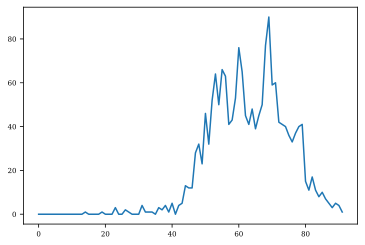

In [14]:
data.LO.plot()

<AxesSubplot:>

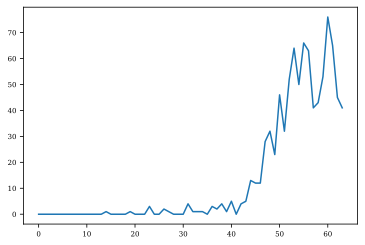

In [15]:
real_LO.plot()

In [16]:
#Initialize parameters
B = []
L = []
real_data = [real_LO,real_PV,real_SO,real_MN, real_MI, real_CO, real_BS, real_MB, real_LC, real_CR, real_BG,real_VA ]
S0=[44928, 71882, 21477, 48835, 1406242, 85543, 196340, 124840, 48058, 72399, 120783, 80724]   #initial susceptible population

for i in range(len(S0)): 
    gamma = 1/11       # 1 / average duration of infectivity period (in days)
    f = 1/5            # 1 / average duration of incubation period (in days)
    s0 = S0[i]
    y0 = s0, 1, 0, 0        # start with 1 infected
    
    true_data = real_data[i]
    t = np.arange(1, len(true_data)+1, 1)
    
    sys.stdout.write('\r' +'EPIDEMIC: '+str(provinces[i]))
    
    BETAS,llkh = metropolis_hastings(iterations,0.3,f,gamma, std, true_data)      # 0.3 = initial beta to calibrate
    
    B.append(BETAS)
    L.append(llkh)

EPIDEMIC: VA

/var/folders/wj/rf_7mtyj4mz92p07_kctx9t80000gn/T/ipykernel_4569/797529210.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wj/rf_7mtyj4mz92p07_kctx9t80000gn/T/ipykernel_4569/797529210.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wj/rf_7mtyj4mz92p07_kctx9t80000gn/T/ipykernel_4569/797529210.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wj/rf_7mtyj4mz92p07_kctx9t80000gn/T/ipykernel_4569/797529210.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wj/rf_7mtyj4mz92p07_kctx9t80000gn/T/ipykernel_4

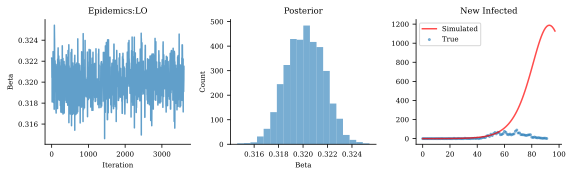

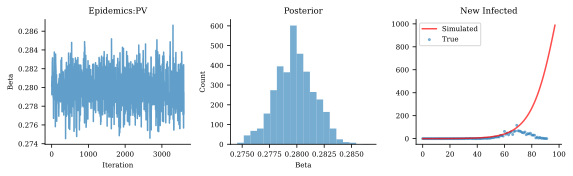

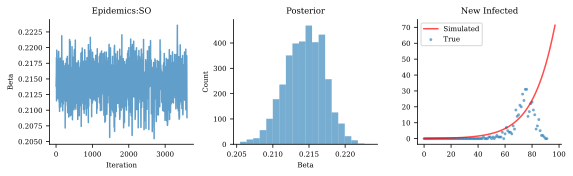

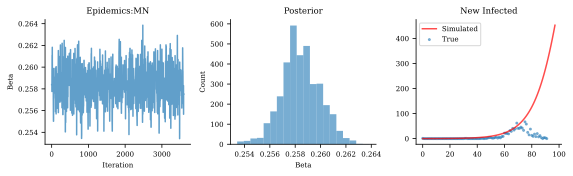

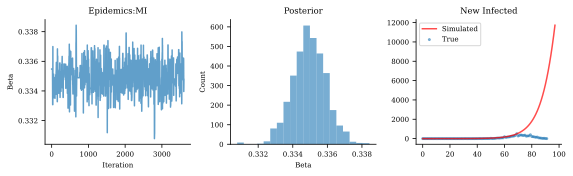

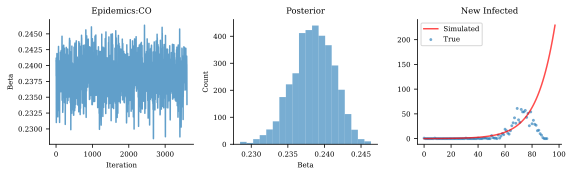

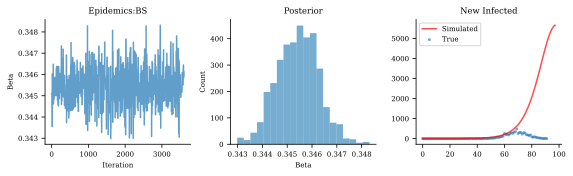

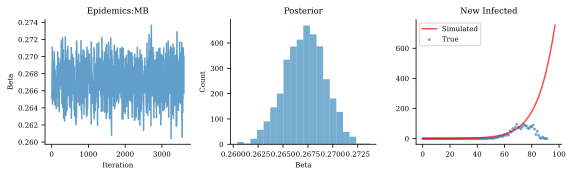

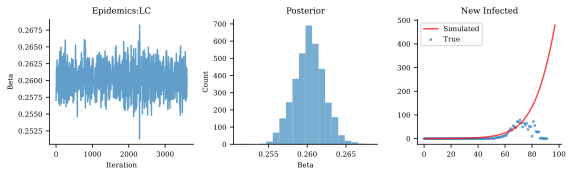

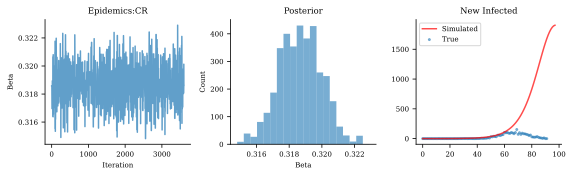

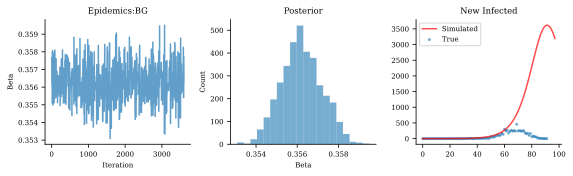

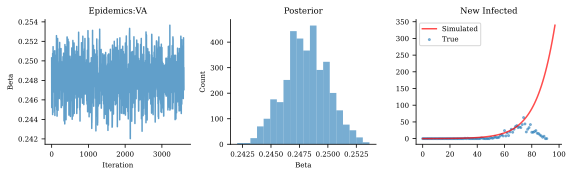

In [17]:
# Plots
for i in range(len(S0)):
    
    true_data =data.iloc[:,i]
    gamma = 1/11
    
    BETAS = B[i]
    fig, axs = plt.subplots(1,3, facecolor='w', figsize=(8,2.5))
    
    axs[0].set_title('Epidemics:{}'.format(provinces[i]))
    axs[1].set_title('Posterior')
    axs[2].set_title('New Infected')

    axs[0].plot(range(len(BETAS)), BETAS, alpha = 0.7)
    axs[1].hist(BETAS, bins = 20, alpha = 0.6)
    
    
    # Simulate for the whole period the Best model: 
    t = np.arange(1, 100, 1)
    
    s0 = S0[i]
    y0 = s0,0, 1, 0
    
    RES = odeint(SEIR_eq, y0, t, args=(np.mean(BETAS),f, gamma))
    I_hat, R = RES.T[2:]
    I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])
    
    axs[2].scatter(range(len(true_data)),true_data,  alpha = 0.5, label = 'True', s = 4)
    axs[2].plot(range(len(I_daily)),I_daily,  alpha = 0.7, color = 'red',  label = 'Simulated')
    
    axs[2].legend(fancybox = True)

    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Beta')
    axs[1].set_xlabel('Beta')
    axs[1].set_ylabel('Count')
    
    
    for i in range(3):
        for spine in ('top', 'right'): 
            axs[i].spines[spine].set_visible(False)

    fig.tight_layout()
    fig.show()

In [11]:
#Beta calibrated for each province
for i in range (12):
    print(provinces[i] + " : " + str(np.mean(B[i])))

LO : 0.3201125580747487
PV : 0.2798173960748387
SO : 0.21447921868216274
MN : 0.2584715021711493
MI : 0.33490148322610835
CO : 0.23840287921456363
BS : 0.3453578238868071
MB : 0.2672688267775874
LC : 0.2602890273623323
CR : 0.31859158261432907
BG : 0.35624150629524565
VA : 0.24822150891553627


# Exercise 2

For the second task we focus only on the province of Lodi and build a simple SIR model with age structure, where the interaction between individuals of different age classes is defined by the mixing matrix where the element cij indicates the average number of contact between individual i and j. 

In [15]:
# data on the distribution of the population by age groups in Italian provinces
age_data = pd.read_csv('DCIS_POPRES1_14032021004311347.csv')

# a little bit of data cleaning
age_data = age_data[(age_data['Territorio'] == 'Lodi') & 
                    (age_data['Stato civile'] == 'totale') &
                    (age_data['Sesso'] == 'totale')]\
                    .loc[:,['Età', 'Value']]\
                    .rename(columns={'Età':'Age_str', 'Value':'Population'})\
                    .reset_index(drop=True)

# create 5-year age intervals as in the contact matrix
age_data['Age'] = np.arange(102)
age_group = []
for i in range(16):
    for j in range(5):
        age_group.append(i)
age_group += [15]*22
age_data['Age_group'] = age_group
age_data.drop(index=101, columns=['Age_str'], inplace=True)
age_data = age_data.groupby('Age_group').sum().drop(columns='Age')
age_data.index = ['0-4','5-9','10-14','15-19','20-24','25-30','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75+'] 
age_data

,Population
0-4,1702
5-9,1907
10-14,1976
15-19,1990
20-24,2141
25-30,2369
30-34,2529
35-39,2626
40-44,3090
45-49,3534


In [16]:
#Total population 
total_pop = age_data.sum()
total_pop

Population    44928
dtype: int64

In [17]:
#Proportions for each age group
age_data['Proportion'] = age_data/ total_pop
age_data

,Population,Proportion
0-4,1702,0.037883
5-9,1907,0.042446
10-14,1976,0.043981
15-19,1990,0.044293
20-24,2141,0.047654
25-30,2369,0.052729
30-34,2529,0.056290
35-39,2626,0.058449
40-44,3090,0.068777
45-49,3534,0.078659


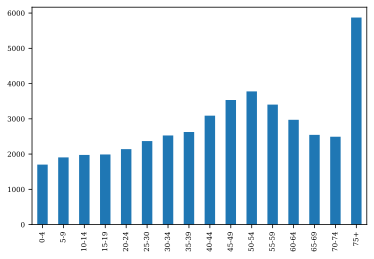

In [18]:
#bars plot
age_data['Population'].plot(kind='bar')

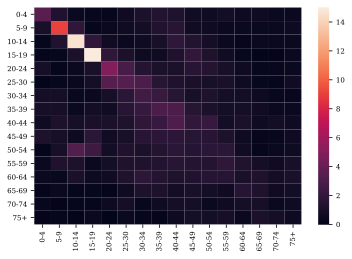

In [19]:
# load contact matrix
contact_matrix = pd.read_csv('italian_matrix.csv').drop(columns='Unnamed: 0')
contact_matrix.columns = ['0-4','5-9','10-14','15-19','20-24','25-30','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75+'] 
contact_matrix.index = ['0-4','5-9','10-14','15-19','20-24','25-30','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75+'] 
sns.heatmap(contact_matrix, vmin=0, vmax=15)

In [20]:
#SIR model
def SIR_eq(INPUT, t, n, BETA, gamma):
    # NB:  S = INPUT[ :16], I = INPUT[16:32], R = INPUT[32:]
    Y = np.zeros((16*3))
    V = INPUT
    k = 16
    for i in range(k):
        SUM = np.dot(BETA[i], V[k:k*2]) * V[i]
        Y[i] = -SUM
        Y[(k+i)] = SUM - (gamma * V[(k+i)])
        Y[(2*k+i)] = gamma * V[(k+i)]
    return Y

In [21]:
def metropolis_hastings(iterations, y0, n, q_start, gamma, t, std, true_data, contact_matrix):
    BETA_start = (q_start * contact_matrix).values
    RES = odeint(SIR_eq, y0, t, args=(n, BETA_start, gamma))
    I_hat = RES.T[16:32].sum(axis=0)         # total infected (aggregate over age groups)
    R = RES.T[32:].sum(axis=0)               # total recovered (aggregate over age groups)
    I_daily = (I_hat[1:]+R[1:]) - (I_hat[:-1]+R[:-1])
    llkh_start = loglikelihood(true_data, I_daily)
    
    Qs =[q_start]
    llkh = [llkh_start]
    
    for ITER in range(iterations):
        
        q_current = Qs[-1]
        llkh_current = llkh[-1]

        q_new = np.random.normal(q_current, std, size=1)[0]
        BETA_new = (q_new * contact_matrix).values
        RES = odeint(SIR_eq, y0, t, args=(n, BETA_new, gamma))
        I_hat = RES.T[16:32].sum(axis=0)     # sum of infected over age groups
        R = RES.T[32:].sum(axis=0)           # sum of recovered over age groups
        I_daily = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])
        llkh_new = loglikelihood(true_data, I_daily)

        alpha  = np.e**(llkh_new - llkh_current)

        if alpha <= np.random.uniform(0,1): 
            Qs.append(q_current)
            llkh.append(llkh_current)

        else: 
            Qs.append(q_new)
            llkh.append(llkh_new)
      
    # We discard the first 1000 iterations. 

    Qs = Qs[1000:] 
    llkh = llkh[1000:]
    
    return np.array(Qs).flatten(), np.array(llkh).flatten()

In [22]:
#TIME VARIABLE
T = 64 
t = np.arange(1, T + 1) 

gamma = 1/11       # 1 / average duration of infectivity period (in days)

n = age_data['Proportion'].values # Proportion of the population in each class

# INITIALIZE POPULATION
N = total_pop.values

S = (N - 1) * n 
I = np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0])      #start infection from a random age group (35-39 in this case)
R = np.array([0]*16)

INPUT = np.hstack((S, I, R)) / N

In [25]:
np.random.seed(17)
# Parameter of the MCMC
iterations = 10000
std = 0.0005

#LODI's data
true_data = data.loc[:63, 'LO'] / N     #work in proportions 

Qs,llkh = metropolis_hastings(iterations, INPUT, n, 0.30, gamma, t, std,true_data, contact_matrix) #0.2=initial q to calibrate

<ipython-input-5-9c94622a0431>:4: RuntimeWarning: divide by zero encountered in log
  llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i])) #poisson likelihood to observe the data with a model
<ipython-input-21-ea57a075a360>:25: RuntimeWarning: invalid value encountered in double_scalars
  alpha  = np.e**(llkh_new - llkh_current)


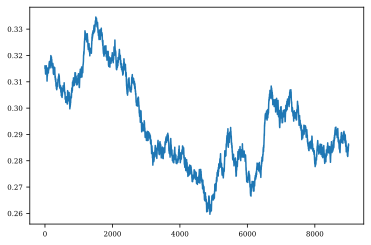

In [26]:
plt.plot(Qs)

In [20]:
#Calibrated q
print('Calibrated q:', np.mean(Qs))

Calibrated q: 0.24045046523040658


<ipython-input-21-7c22d075e572>:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


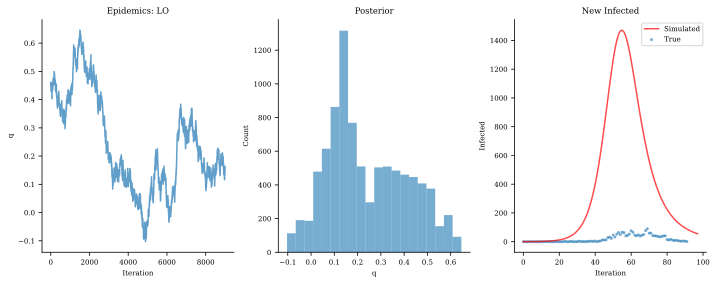

In [21]:
#Plots
fig, axs = plt.subplots(1,3, facecolor='w', figsize=(10,4))
axs[0].set_title('Epidemics: {}'.format('LO'))
axs[1].set_title('Posterior')
axs[2].set_title('New Infected')

axs[0].plot(range(len(Qs)), Qs, alpha = 0.7)
axs[1].hist(Qs, bins = 20, alpha = 0.6)
    
    
# Simulate for the whole period the Best model: 
t = np.arange(1, 100, 1)

S = (N - 1) * n 
I = np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0])  #start infection from a random age group (35-39 in this case)
R = np.array([0]*16)

INPUT = np.hstack((S, I, R)) / N

best_q = np.mean(Qs)
BETA = (best_q * contact_matrix).values
RES = odeint(SIR_eq, INPUT, t, args=(n, BETA, gamma))
I_hat = RES.T[16:32].sum(axis=0)   # sum of infected over age groups
R = RES.T[32:].sum(axis=0)
I_daily = ((I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1]))

#axs[2].scatter(range(len(true_data)), true_data * N,  alpha=0.5, label='True', s=4)
axs[2].scatter(range(len(data['LO'])), data['LO'],  alpha=0.5, label='True', s=4)
axs[2].plot(range(len(I_daily)), I_daily * N, alpha=0.7, color='red',  label='Simulated')
    
axs[2].legend(fancybox = True)

axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('q')
axs[1].set_xlabel('q')
axs[1].set_ylabel('Count')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Infected')
    
for i in range(3):
    for spine in ('top', 'right'):
        axs[i].spines[spine].set_visible(False)

fig.tight_layout()
fig.show()

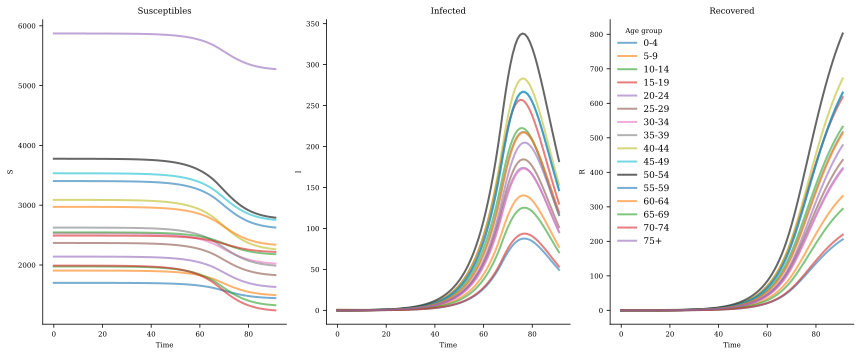

In [40]:
#SIR Plots for each age group

S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15 = RES.T[:16] * N
I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15 = RES.T[16:32] * N
R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14,R15 = RES.T[32:] * N
 
fig, axs = plt.subplots(nrows=1, ncols=3, facecolor='w', figsize=(12,5))

ax = axs[0]
ax.set_title('Susceptibles')
ax.plot(t, S0,alpha=0.6, lw=2)
ax.plot(t, S1, alpha=0.6, lw=2)
ax.plot(t, S2, alpha=0.6, lw=2)
ax.plot(t, S3, alpha=0.6, lw=2)
ax.plot(t, S4, alpha=0.6, lw=2)
ax.plot(t, S5, alpha=0.6, lw=2)
ax.plot(t, S6, alpha=0.6, lw=2)
ax.plot(t, S7, alpha=0.6, lw=2)
ax.plot(t, S8, alpha=0.6, lw=2)
ax.plot(t, S9, alpha=0.6, lw=2)
ax.plot(t, S10, color='black', alpha=0.6, lw=2)
ax.plot(t, S11, alpha=0.6, lw=2)
ax.plot(t, S12, alpha=0.6, lw=2)
ax.plot(t, S13, alpha=0.6, lw=2)
ax.plot(t, S14, alpha=0.6, lw=2)
ax.plot(t, S15, alpha=0.6, lw=2)
ax.set_xlabel('Time')
ax.set_ylabel('S')
   
ax = axs[1]
ax.set_title('Infected')
ax.plot(t, I0, alpha=0.6, lw=2)
ax.plot(t, I1, alpha=0.6, lw=2)
ax.plot(t, I2, alpha=0.6, lw=2)
ax.plot(t, I3, alpha=0.6, lw=2)
ax.plot(t, I4, alpha=0.6, lw=2)
ax.plot(t, I5, alpha=0.6, lw=2)
ax.plot(t, I6, alpha=0.6, lw=2)
ax.plot(t, I7, alpha=0.6, lw=2)
ax.plot(t, I8, alpha=0.6, lw=2)
ax.plot(t, I9, alpha=0.6, lw=2)
ax.plot(t, I10, color='black', alpha=0.6, lw=2)
ax.plot(t, I11, alpha=0.6, lw=2)
ax.plot(t, I12, alpha=0.6, lw=2)
ax.plot(t, I13, alpha=0.6, lw=2)
ax.plot(t, I14, alpha=0.6, lw=2)
ax.plot(t, I15, alpha=0.6, lw=2)
ax.set_xlabel('Time')
ax.set_ylabel('I')

ax = axs[2]
ax.set_title('Recovered')
ax.plot(t, R0, alpha=0.6, lw=2, label='0-4')
ax.plot(t, R1, alpha=0.6, lw=2, label='5-9')
ax.plot(t, R2, alpha=0.6, lw=2, label='10-14')
ax.plot(t, R3, alpha=0.6, lw=2, label='15-19')
ax.plot(t, R4, alpha=0.6, lw=2, label='20-24')
ax.plot(t, R5, alpha=0.6, lw=2, label='25-29')
ax.plot(t, R6, alpha=0.6, lw=2, label='30-34')
ax.plot(t, R7, alpha=0.6, lw=2, label='35-39')
ax.plot(t, R8, alpha=0.6, lw=2, label='40-44')
ax.plot(t, R9, alpha=0.6, lw=2, label='45-49')
ax.plot(t, R10, color='black', alpha=0.6, lw=2, label='50-54')
ax.plot(t, R11, alpha=0.6, lw=2, label='55-59')
ax.plot(t, R12, alpha=0.6, lw=2, label='60-64')
ax.plot(t, R13, alpha=0.6, lw=2, label='65-69')
ax.plot(t, R14, alpha=0.6, lw=2, label='70-74')
ax.plot(t, R15, alpha=0.6, lw=2, label='75+')
ax.set_xlabel('Time')
ax.set_ylabel('R')
ax.legend(loc='upper left', fontsize=9, frameon=False, title = 'Age group') # upper left corner
fig.tight_layout()
for aa in range(3):
    ax = axs[aa]
    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)

In [28]:
#Computig the dominant eigen value 
eigen_c = np.linalg.eigvals(contact_matrix * n)
dominant_eigen_c = max(np.real(eigen_c))
print('dominant_eigen_c:{}'.format(dominant_eigen_c))

dominant_eigen_c:1.1341397526182004


In [29]:
#Computig R0:
(np.mean(Qs) / gamma) * dominant_eigen_c 

2.3465249675693807

# Exercise 3

Include the following event in our model:

**National lockdown**, i.e. a big proportion of the population is forced to stay home and avoid contacts, as a result of schools being closed, smart-working, etc. These measures reduce the number of contacts, so they have an effect on the contact matrix. This lockdown is enforced after approximately 1 month since the beginning of the pandemics.


How is this implemented:
- The starting parameters are the *q* calibrated in the last exercise (approximately 0.20) and the starting contact matrix.

- Starting from day 69 (9th March), national lockdown is enforced. Schools and universities are closed (reduction of contacts in 0 to 24 years old age groups), smart-working starts being adopted, age groups more at risk start isolating themselves. People can only go out and have contacts if they are essential workers or have to perform essential activities (e.g. buying food). This tremendously reduces the number of contacts. After day 68, we let the R0 decline ata rate of exp(t·10^−3)

In [35]:
#SIR model with lockdown
def SIR_model(INPUT, T, q, contact_matrix, gamma):
    
    lockdown_t = 68 # time before lockdown (started 9 March)
    k = 16 # number of age groups
    RES = np.zeros((T, 48)) # create a T x 48 matrix to store the output
    RES[0,:] = INPUT
    q_evolution = []
    
    for t in range(1, T):
        current = np.zeros((48))
        previous = RES[t - 1,:]
        if t > lockdown_t:
            q = q * np.exp(-0.001*t) # slowly decreasing infectiveness at each iteration after lockdown
        BETA = (q * contact_matrix).values
        q_evolution.append(q)
        for i in range(k):
            SUM = np.dot(BETA[i], previous[k:k*2]) * previous[i]
            current[i] = previous[i] - SUM
            current[k+i] = previous[k+i] + SUM - (gamma * previous[(k+i)])
            current[2*k+i] = previous[2*k+i] + gamma * previous[(k+i)]
        RES[t,:] = current
        
    return RES, q_evolution

In [36]:
# Disease parameters
q = np.mean(Qs) 
gamma = 1/11 #  1 / average duration of infectivity period (in days)

# Population parameters
n = age_data['Proportion'].values # Proportion of the population in each class
N = total_pop.values #/ 8

# Time parameters
T = len(data['LO']) # 92 days

# Input 
S = (N - 1) * n 
I = np.array([0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]) #start infection from a random age group (35-39 in this case)
R = np.array([0]*16)

INPUT = np.hstack((S, I, R)) / N

RES, q_evolution = SIR_model(INPUT, T, q, contact_matrix, gamma)

# compute new cases 
S_hat = RES.T[0:16].sum(axis=0)
I_hat = RES.T[16:32].sum(axis=0)   # sum of infected over age groups
R_hat = RES.T[32:].sum(axis=0)
I_daily = ((I_hat[1:]+R_hat[1:])-(I_hat[:-1]+R_hat[:-1]))

Text(0, 0.5, 'Infected')

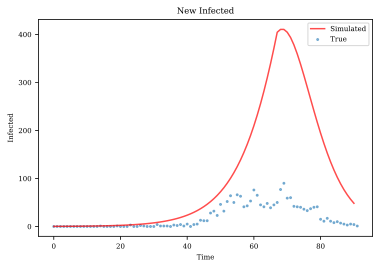

In [37]:
#Plot of new infected in Lodi
plt.scatter(range(len(data['LO'])), data['LO'],  alpha=0.5, label='True', s=4)
plt.plot(range(len(I_daily)), I_daily * N, alpha=0.7, color='red',  label='Simulated')
plt.legend()
plt.title('New Infected')
plt.xlabel('Time')
plt.ylabel('Infected')

Text(0, 0.5, 'R0')

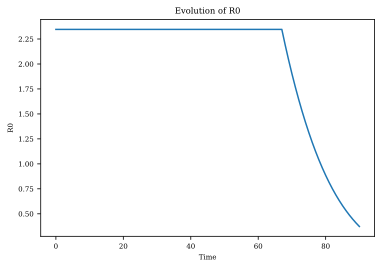

In [38]:
#R0:
R0s = (np.array(q_evolution) / gamma) * dominant_eigen_c 
plt.plot(R0s)
plt.title('Evolution of R0')
plt.xlabel('Time')
plt.ylabel('R0')

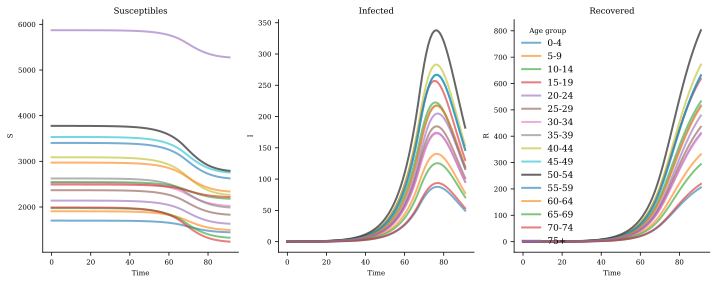

In [41]:
#Plots for each age group
S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15 = RES.T[:16] * N
I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15 = RES.T[16:32] * N
R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14,R15 = RES.T[32:] * N

t = np.arange(0, 92, 1)
 
fig, axs = plt.subplots(nrows=1, ncols=3, facecolor='w', figsize=(10,4))

ax = axs[0]
ax.set_title('Susceptibles')
ax.plot(t, S0, alpha=0.6, lw=2)
ax.plot(t, S1, alpha=0.6, lw=2)
ax.plot(t, S2, alpha=0.6, lw=2)
ax.plot(t, S3, alpha=0.6, lw=2)
ax.plot(t, S4, alpha=0.6, lw=2)
ax.plot(t, S5, alpha=0.6, lw=2)
ax.plot(t, S6, alpha=0.6, lw=2)
ax.plot(t, S7, alpha=0.6, lw=2)
ax.plot(t, S8, alpha=0.6, lw=2)
ax.plot(t, S9, alpha=0.6, lw=2)
ax.plot(t, S10, color='black', alpha=0.6, lw=2)
ax.plot(t, S11, alpha=0.6, lw=2)
ax.plot(t, S12, alpha=0.6, lw=2)
ax.plot(t, S13, alpha=0.6, lw=2)
ax.plot(t, S14, alpha=0.6, lw=2)
ax.plot(t, S15, alpha=0.6, lw=2)
ax.set_xlabel('Time')
ax.set_ylabel('S')
   
ax = axs[1]
ax.set_title('Infected')
ax.plot(t, I0, alpha=0.6, lw=2)
ax.plot(t, I1, alpha=0.6, lw=2)
ax.plot(t, I2, alpha=0.6, lw=2)
ax.plot(t, I3, alpha=0.6, lw=2)
ax.plot(t, I4, alpha=0.6, lw=2)
ax.plot(t, I5, alpha=0.6, lw=2)
ax.plot(t, I6, alpha=0.6, lw=2)
ax.plot(t, I7, alpha=0.6, lw=2)
ax.plot(t, I8, alpha=0.6, lw=2)
ax.plot(t, I9, alpha=0.6, lw=2)
ax.plot(t, I10, color='black', alpha=0.6, lw=2)
ax.plot(t, I11, alpha=0.6, lw=2)
ax.plot(t, I12, alpha=0.6, lw=2)
ax.plot(t, I13, alpha=0.6, lw=2)
ax.plot(t, I14, alpha=0.6, lw=2)
ax.plot(t, I15, alpha=0.6, lw=2)
ax.set_xlabel('Time')
ax.set_ylabel('I')

ax = axs[2]
ax.set_title('Recovered')
ax.plot(t, R0, alpha=0.6, lw=2, label='0-4')
ax.plot(t, R1, alpha=0.6, lw=2, label='5-9')
ax.plot(t, R2, alpha=0.6, lw=2, label='10-14')
ax.plot(t, R3, alpha=0.6, lw=2, label='15-19')
ax.plot(t, R4, alpha=0.6, lw=2, label='20-24')
ax.plot(t, R5, alpha=0.6, lw=2, label='25-29')
ax.plot(t, R6, alpha=0.6, lw=2, label='30-34')
ax.plot(t, R7, alpha=0.6, lw=2, label='35-39')
ax.plot(t, R8, alpha=0.6, lw=2, label='40-44')
ax.plot(t, R9, alpha=0.6, lw=2, label='45-49')
ax.plot(t, R10, color='black', alpha=0.6, lw=2, label='50-54')
ax.plot(t, R11, alpha=0.6, lw=2, label='55-59')
ax.plot(t, R12, alpha=0.6, lw=2, label='60-64')
ax.plot(t, R13, alpha=0.6, lw=2, label='65-69')
ax.plot(t, R14, alpha=0.6, lw=2, label='70-74')
ax.plot(t, R15, alpha=0.6, lw=2, label='75+')
ax.set_xlabel('Time')
ax.set_ylabel('R')
ax.legend(loc='upper left', fontsize=9, frameon=False, title = 'Age group') # upper left corner
fig.tight_layout()
for aa in range(3):
    ax = axs[aa]
    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)